In [1]:
import numpy as np 
import pandas as pd 

df = pd.DataFrame(pd.read_csv("Seattle_Police_Department_Police_Report_Incident.csv"))
df.fillna(0, inplace=True)
df1= df[~((df[['General Offense Number']].duplicated(keep=False))) & (df.isnull().any(axis=1))]
## Has no duplicate entries for General Offense Number now 
df1 = df[(df['Year'] > 2012)]

In [2]:
df1.head()

,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Date Reported,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year
0,887754,201378203,2299,2,BURGLARY-SECURE PARKING-RES,2299,BURGLARY-SECURE PARKING-RES,03/07/2013 04:29:00 PM,03/07/2013 04:29:00 PM,0,60XX BLOCK OF PHINNEY AV N,B,B2,3500.2037,-122.354378,47.672829,"(47.672828674, -122.354377747)",3,2013
3,1032238,201472111,2404,8,VEH-THEFT-TRUCK,2400,VEHICLE THEFT,03/08/2014 06:57:00 AM,03/07/2014 10:00:00 PM,03/08/2014 06:30:00 AM,CHERRY ST / 2 AV,K,K1,8100.2036,-122.333176,47.603016,"(47.6030159, -122.333175659)",3,2014
4,1032239,2014107311,2202,0,BURGLARY-FORCE-RES,2200,BURGLARY,04/08/2014 03:59:00 PM,04/08/2014 10:30:00 AM,04/08/2014 03:59:00 PM,130XX BLOCK OF 25 AV NE,L,L1,200.2001,-122.301888,47.723846,"(47.723846436, -122.301887512)",4,2014
5,887755,201377887,2299,2,BURGLARY-SECURE PARKING-RES,2299,BURGLARY-SECURE PARKING-RES,03/07/2013 11:59:00 AM,03/05/2013 03:30:00 PM,03/06/2013 07:15:00 AM,1XX BLOCK OF 6 AV N,Q,Q3,7200.1075,-122.345009,47.619144,"(47.61914444, -122.34500885)",3,2013
6,1032241,2014123990,2404,1,VEH-THEFT-AUTO,2400,VEHICLE THEFT,04/23/2014 08:29:00 AM,04/22/2014 06:15:00 PM,04/23/2014 08:25:00 AM,22XX BLOCK OF NW 64 ST,B,B1,3300.4006,-122.386162,47.675289,"(47.675289154, -122.386161804)",4,2014


# Data Exploration


The link at the bottom of this notebook provides a detailed map of how the districts and zone/beats are defined within the Seattle City Limits. Lets take a look at how much crime occurs in downtown Seattle:

In [3]:
m = []
for line in df1['District/Sector']:
    if line == 'M':
        m.append(line)
        



In [4]:
print(len(m)/len(df1['District/Sector']))
len(m)

0.08296507684218554


41341

Approximately 8% of all the reported crime events in Seattle take place in downtown. A bit high, but not too suprising if you've ever driven past Pike and Pine after 10PM. 

In [5]:
df1.groupby('District/Sector').count()['RMS CDW ID']

District/Sector
0       613
99      785
B     34797
C     21714
D     32868
E     39640
F     24905
G     22594
J     26683
K     30971
L     28682
M     41341
N     32545
O     15827
Q     31553
R     27211
S     22018
SE        2
U     38854
W     24691
Name: RMS CDW ID, dtype: int64

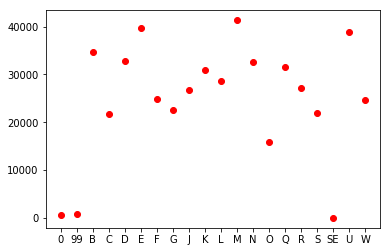

In [6]:
import matplotlib.pyplot as plt

plt.plot(df1['District/Sector'].value_counts(), 'ro')
plt.show()

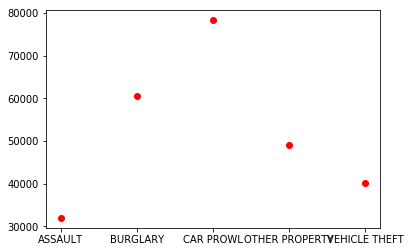

In [7]:
plt.plot(df1['Summarized Offense Description'].value_counts()[:5], 'ro')
plt.show()

In [8]:
df1 = df1.drop(['RMS CDW ID','Offense Type','Offense Code','Date Reported','Location','General Offense Number','Occurred Date Range End','Hundred Block Location','Offense Code Extension','Summary Offense Code','Latitude','Longitude'],axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498294 entries, 0 to 766471
Data columns (total 7 columns):
Summarized Offense Description       498294 non-null object
Occurred Date or Date Range Start    498294 non-null object
District/Sector                      498294 non-null object
Zone/Beat                            498294 non-null object
Census Tract 2000                    498294 non-null float64
Month                                498294 non-null int64
Year                                 498294 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 30.4+ MB


A half a million data points is a lot to work with. In order to make this dataset more malleable, we will do some very light feature engineering to change the resolution of the types of crime; we will no longer look at individual types of offenses but instead classify them in terms of severity:

In [9]:
df2 = df1.copy()
df2['Severity'] = 'LOW'
sev_high = ['ASSAULT', 'HOMICIDE', 'NARCOTICS', 'ROBBERY', 'THREATS', 'VEHICLE THEFT', 'WEAPON','BURGLARY']
sev_med  = ['BIKE THEFT','BURGLARY-SECURE PARKING-RES','CAR PROWL','COUNTERFEIT','DUI','EMBEZZLE','FORGERY','FRAUD','INJURY','LOST PROPERTY','OBSTRUCT','OTHER PROPERTY','PICKPOCKET','PROPERTY DAMAGE','PROSTITUTION','STOLEN PROPERTY','TRAFFIC','WARRANT ARREST']


df2.loc[df['Summarized Offense Description'].isin(sev_high), 'Severity'] = 'HIGH'
df2.loc[df['Summarized Offense Description'].isin(sev_med), 'Severity'] = 'MED'

# Filter and display

df_sev = df2.groupby(['Severity']).size().reset_index(name='incidents')
df_sev.head()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498294 entries, 0 to 766471
Data columns (total 8 columns):
Summarized Offense Description       498294 non-null object
Occurred Date or Date Range Start    498294 non-null object
District/Sector                      498294 non-null object
Zone/Beat                            498294 non-null object
Census Tract 2000                    498294 non-null float64
Month                                498294 non-null int64
Year                                 498294 non-null int64
Severity                             498294 non-null object
dtypes: float64(1), int64(2), object(5)
memory usage: 34.2+ MB


In [10]:
df2['Hour'] = (pd.to_datetime(df2['Occurred Date or Date Range Start'])).dt.hour

An interesting measurand for our model would be whether or not a crime occurred at night. Of course, "night" is very subjective, but it is definitely not encoded by just AM or PM. The following cell encodes whether a crime occurred at night or not based on the definition that "night" is between the hours of 7PM and 6AM. This will then be imbibed into our dataframe and be used as a feature in place of the Date & Time column. 

In [11]:
day_night = []
for i in df2['Hour']:

    if i > 19 or i < 6 :
        day_night.append('Night')
    elif 6 <= i <= 19:
        day_night.append('Day')
day_night

['Day',
 'Night',
 'Day',
 'Day',
 'Day',
 'Night',
 'Night',
 'Night',
 'Day',
 'Night',
 'Day',
 'Day',
 'Day',
 'Day',
 'Day',
 'Night',
 'Day',
 'Day',
 'Night',
 'Day',
 'Night',
 'Day',
 'Night',
 'Night',
 'Night',
 'Night',
 'Night',
 'Day',
 'Night',
 'Night',
 'Day',
 'Night',
 'Day',
 'Day',
 'Day',
 'Night',
 'Day',
 'Night',
 'Night',
 'Night',
 'Day',
 'Day',
 'Night',
 'Day',
 'Night',
 'Day',
 'Day',
 'Day',
 'Day',
 'Day',
 'Night',
 'Day',
 'Day',
 'Day',
 'Day',
 'Day',
 'Day',
 'Day',
 'Night',
 'Night',
 'Day',
 'Night',
 'Day',
 'Day',
 'Night',
 'Night',
 'Day',
 'Night',
 'Day',
 'Night',
 'Night',
 'Day',
 'Day',
 'Day',
 'Day',
 'Day',
 'Day',
 'Night',
 'Day',
 'Night',
 'Day',
 'Day',
 'Day',
 'Day',
 'Night',
 'Day',
 'Night',
 'Day',
 'Day',
 'Day',
 'Day',
 'Night',
 'Night',
 'Day',
 'Day',
 'Day',
 'Day',
 'Day',
 'Night',
 'Day',
 'Night',
 'Day',
 'Night',
 'Day',
 'Day',
 'Night',
 'Night',
 'Day',
 'Night',
 'Day',
 'Day',
 'Day',
 'Day',
 'Day',
 '

In [12]:
from sklearn.preprocessing import LabelBinarizer
one_hot = LabelBinarizer()
one_hot.fit_transform(day_night)

array([[0],
       [1],
       [0],
       ..., 
       [0],
       [0],
       [1]])

In [13]:
one_hot.classes_

array(['Day', 'Night'],
      dtype='<U5')

In [14]:
daynight = pd.Series(day_night)
daynight_cols = pd.get_dummies(daynight)
daynight_df = pd.DataFrame(daynight_cols)
daynight_df.head()

,Day,Night
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [15]:
df2 = df2.reset_index(drop=True)
frames = [df2,daynight_df]
df2.head()

,Summarized Offense Description,Occurred Date or Date Range Start,District/Sector,Zone/Beat,Census Tract 2000,Month,Year,Severity,Hour
0,BURGLARY-SECURE PARKING-RES,03/07/2013 04:29:00 PM,B,B2,3500.2037,3,2013,MED,16
1,VEHICLE THEFT,03/07/2014 10:00:00 PM,K,K1,8100.2036,3,2014,HIGH,22
2,BURGLARY,04/08/2014 10:30:00 AM,L,L1,200.2001,4,2014,HIGH,10
3,BURGLARY-SECURE PARKING-RES,03/05/2013 03:30:00 PM,Q,Q3,7200.1075,3,2013,MED,15
4,VEHICLE THEFT,04/22/2014 06:15:00 PM,B,B1,3300.4006,4,2014,HIGH,18


In [16]:
df3 = pd.concat(frames,axis=1,join_axes=[df2.index])
df3.head()

,Summarized Offense Description,Occurred Date or Date Range Start,District/Sector,Zone/Beat,Census Tract 2000,Month,Year,Severity,Hour,Day,Night
0,BURGLARY-SECURE PARKING-RES,03/07/2013 04:29:00 PM,B,B2,3500.2037,3,2013,MED,16,1,0
1,VEHICLE THEFT,03/07/2014 10:00:00 PM,K,K1,8100.2036,3,2014,HIGH,22,0,1
2,BURGLARY,04/08/2014 10:30:00 AM,L,L1,200.2001,4,2014,HIGH,10,1,0
3,BURGLARY-SECURE PARKING-RES,03/05/2013 03:30:00 PM,Q,Q3,7200.1075,3,2013,MED,15,1,0
4,VEHICLE THEFT,04/22/2014 06:15:00 PM,B,B1,3300.4006,4,2014,HIGH,18,1,0


In [17]:
import datetime 
weekday = []
for i in df3['Occurred Date or Date Range Start']:
    A = pd.to_datetime(i).weekday()
    weekday.append(A)


In [18]:
weekday_df = pd.DataFrame(pd.get_dummies(pd.Series(weekday)))
weekday_df.columns = ['M','T','W','Th','F','Sa','Su']

In [19]:
frames1 = [weekday_df, df3]
df3

,Summarized Offense Description,Occurred Date or Date Range Start,District/Sector,Zone/Beat,Census Tract 2000,Month,Year,Severity,Hour,Day,Night
0,BURGLARY-SECURE PARKING-RES,03/07/2013 04:29:00 PM,B,B2,3500.2037,3,2013,MED,16,1,0
1,VEHICLE THEFT,03/07/2014 10:00:00 PM,K,K1,8100.2036,3,2014,HIGH,22,0,1
2,BURGLARY,04/08/2014 10:30:00 AM,L,L1,200.2001,4,2014,HIGH,10,1,0
3,BURGLARY-SECURE PARKING-RES,03/05/2013 03:30:00 PM,Q,Q3,7200.1075,3,2013,MED,15,1,0
4,VEHICLE THEFT,04/22/2014 06:15:00 PM,B,B1,3300.4006,4,2014,HIGH,18,1,0
5,VEHICLE THEFT,04/24/2014 05:30:00 AM,J,J2,3000.4011,4,2014,HIGH,5,0,1
6,ROBBERY,04/19/2014 11:30:00 PM,D,D3,7300.2005,4,2014,HIGH,23,0,1
7,VEHICLE THEFT,04/21/2014 10:30:00 PM,N,N3,1200.5011,4,2014,HIGH,22,0,1
8,BURGLARY,03/08/2013 05:00:00 PM,M,M2,7200.1065,3,2013,HIGH,17,1,0
9,BURGLARY,03/04/2013 08:00:00 PM,C,C3,6300.4020,3,2013,HIGH,20,0,1


In [20]:
df4 = pd.concat(frames1, axis=1,join_axes=[df3.index])
df4

,M,T,W,Th,F,Sa,Su,Summarized Offense Description,Occurred Date or Date Range Start,District/Sector,Zone/Beat,Census Tract 2000,Month,Year,Severity,Hour,Day,Night
0,0,0,0,1,0,0,0,BURGLARY-SECURE PARKING-RES,03/07/2013 04:29:00 PM,B,B2,3500.2037,3,2013,MED,16,1,0
1,0,0,0,0,1,0,0,VEHICLE THEFT,03/07/2014 10:00:00 PM,K,K1,8100.2036,3,2014,HIGH,22,0,1
2,0,1,0,0,0,0,0,BURGLARY,04/08/2014 10:30:00 AM,L,L1,200.2001,4,2014,HIGH,10,1,0
3,0,1,0,0,0,0,0,BURGLARY-SECURE PARKING-RES,03/05/2013 03:30:00 PM,Q,Q3,7200.1075,3,2013,MED,15,1,0
4,0,1,0,0,0,0,0,VEHICLE THEFT,04/22/2014 06:15:00 PM,B,B1,3300.4006,4,2014,HIGH,18,1,0
5,0,0,0,1,0,0,0,VEHICLE THEFT,04/24/2014 05:30:00 AM,J,J2,3000.4011,4,2014,HIGH,5,0,1
6,0,0,0,0,0,1,0,ROBBERY,04/19/2014 11:30:00 PM,D,D3,7300.2005,4,2014,HIGH,23,0,1
7,1,0,0,0,0,0,0,VEHICLE THEFT,04/21/2014 10:30:00 PM,N,N3,1200.5011,4,2014,HIGH,22,0,1
8,0,0,0,0,1,0,0,BURGLARY,03/08/2013 05:00:00 PM,M,M2,7200.1065,3,2013,HIGH,17,1,0
9,1,0,0,0,0,0,0,BURGLARY,03/04/2013 08:00:00 PM,C,C3,6300.4020,3,2013,HIGH,20,0,1


In [21]:
df5 = df4.drop(['Summarized Offense Description','Occurred Date or Date Range Start','District/Sector','Hour'], axis=1)


In [22]:
df5.head()

,M,T,W,Th,F,Sa,Su,Zone/Beat,Census Tract 2000,Month,Year,Severity,Day,Night
0,0,0,0,1,0,0,0,B2,3500.2037,3,2013,MED,1,0
1,0,0,0,0,1,0,0,K1,8100.2036,3,2014,HIGH,0,1
2,0,1,0,0,0,0,0,L1,200.2001,4,2014,HIGH,1,0
3,0,1,0,0,0,0,0,Q3,7200.1075,3,2013,MED,1,0
4,0,1,0,0,0,0,0,B1,3300.4006,4,2014,HIGH,1,0


In [23]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
le.fit(['HIGH','MED','LOW'])

LabelEncoder()

In [24]:
le_severity = pd.DataFrame(le.transform(df5['Severity']))
le_severity.head()

,0
0,2
1,0
2,0
3,2
4,0


In [25]:
df5['Zone/Beat'].unique()

array(['B2', 'K1', 'L1', 'Q3', 'B1', 'J2', 'D3', 'N3', 'M2', 'C3', 'Q2',
       'G3', 'L2', 'E1', 'S3', 'O3', 'F2', 'W1', 0, 'C1', 'R1', 'M1', 'R3',
       'D1', 'L3', 'W3', 'S2', 'K3', 'E2', 'J1', 'M3', 'N1', 'W2', 'E3',
       'U1', 'K2', 'G1', 'J3', 'Q1', 'S1', 'G2', 'B3', 'N2', 'R2', 'D2',
       'F3', 'F1', 'C2', 'U2', 'U3', 'O2', 'O1', '99', 'WS'], dtype=object)

In [26]:
lec = preprocessing.LabelEncoder()
df5['Zone/Beat'] = lec.fit_transform(df5['Zone/Beat'].astype(str))

In [27]:
df5['Zone/Beat'].unique()

array([ 3, 23, 26, 40,  2, 21, 10, 34, 30,  7, 39, 19, 27, 11, 46, 37, 15,
       50,  0,  5, 41, 29, 43,  8, 28, 52, 45, 25, 12, 20, 31, 32, 51, 13,
       47, 24, 17, 22, 38, 44, 18,  4, 33, 42,  9, 16, 14,  6, 48, 49, 36,
       35,  1, 53])

In [28]:
df5['Severity'] = le_severity ## 2 is MED, 1 is low,0 is high

In [29]:
let = preprocessing.LabelEncoder()
df5['Year'] = let.fit_transform(df5['Year'])
df5.head()

,M,T,W,Th,F,Sa,Su,Zone/Beat,Census Tract 2000,Month,Year,Severity,Day,Night
0,0,0,0,1,0,0,0,3,3500.2037,3,0,2,1,0
1,0,0,0,0,1,0,0,23,8100.2036,3,1,0,0,1
2,0,1,0,0,0,0,0,26,200.2001,4,1,0,1,0
3,0,1,0,0,0,0,0,40,7200.1075,3,0,2,1,0
4,0,1,0,0,0,0,0,2,3300.4006,4,1,0,1,0


In [30]:
from sklearn.model_selection import train_test_split
feat_cols = ['M','T','W','Th','F','Sa','Su','Census Tract 2000', 'Month', 'Year','Severity','Day','Night']
X = df5[feat_cols]
y = df5['Zone/Beat']


In [31]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.fit(X)
X = pca.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=100, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=100,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [33]:
y_pred_class = clf.predict(X_test)

In [34]:
from sklearn import metrics

print("Accuracy score: {0:.4f}".format(metrics.accuracy_score(y_test, y_pred_class)))

Accuracy score: 0.8755


In [36]:
Yloc_test = list(lec.inverse_transform(y_test))


In [37]:
Yloc_pred_class = list(lec.inverse_transform(y_pred_class))


In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class)) # , target_names=target_names))

             precision    recall  f1-score   support

          0       0.70      0.55      0.62       167
          1       0.70      0.65      0.67       205
          2       0.86      0.91      0.88      2723
          3       0.91      0.88      0.90      2909
          4       0.96      0.95      0.96      2973
          5       0.80      0.80      0.80      2077
          6       0.80      0.79      0.79      1648
          7       0.81      0.79      0.80      1705
          8       0.88      0.90      0.89      2889
          9       0.79      0.81      0.80      2781
         10       0.85      0.84      0.85      2469
         11       0.91      0.92      0.91      3185
         12       0.88      0.91      0.89      4133
         13       0.87      0.89      0.88      2598
         14       0.86      0.88      0.87      1889
         15       0.95      0.97      0.96      2283
         16       0.97      0.99      0.98      2079
         17       0.83      0.82      0.82   

In [39]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_class)

array([[  92,   44,    0, ...,    0,    0,    0],
       [  33,  133,    0, ...,    0,    1,    0],
       [   0,    0, 2479, ...,    0,    0,    0],
       ..., 
       [   0,    2,    0, ..., 1650,  130,    0],
       [   0,    0,    0, ...,  220, 1918,   69],
       [   0,    0,    0, ...,    0,   80, 1555]])

While the two cells above can provide some useful insights via sklearn.metrics , I would prefer to see more explicitly defined evaluations of my model: 

In [40]:
index = []
results = []  ## What the true target district was that our model misclassified 
misses = []   ## What the model predicted our target district was when it was incorrect. 
for i in range(len(Yloc_test)):
    
    if Yloc_pred_class[i] != Yloc_test[i]:          
        index.append(i)
        results.append(Yloc_test[i])
        misses.append(Yloc_pred_class[i])
        


In [41]:
misses

['L1',
 'M2',
 'W3',
 'S2',
 'N2',
 'U1',
 'M2',
 'M3',
 'F1',
 'J2',
 'W2',
 'J2',
 'M2',
 'S2',
 'L2',
 'F1',
 'S3',
 'J3',
 'J2',
 'J1',
 'R2',
 'S2',
 'M3',
 'R1',
 'M3',
 'J2',
 'N1',
 'K2',
 'Q2',
 'W2',
 'R2',
 'F3',
 'G1',
 'D2',
 'S2',
 'R1',
 'D1',
 'Q2',
 'Q3',
 'D2',
 'D2',
 'M1',
 'L1',
 'E2',
 'K1',
 'D3',
 'R2',
 'L1',
 'L1',
 'G1',
 'U2',
 'G1',
 'N2',
 'C1',
 'L3',
 'C2',
 'D2',
 'L2',
 'K2',
 'J2',
 'O3',
 'N2',
 'C2',
 'D2',
 'G3',
 'N1',
 'J2',
 'Q1',
 'L1',
 'D3',
 'O1',
 'U2',
 'B2',
 'Q3',
 'D3',
 'O2',
 'Q3',
 'K1',
 'M2',
 '0',
 'C1',
 'L1',
 'U1',
 'N1',
 'B3',
 'K2',
 'J3',
 'E2',
 'N3',
 'C2',
 'S1',
 'E1',
 'B1',
 'F1',
 'O2',
 'E1',
 'E1',
 'F1',
 'L3',
 'M2',
 'D2',
 'U1',
 'Q1',
 'R2',
 'L3',
 'C2',
 'D2',
 'D3',
 'N2',
 'S3',
 'C1',
 'K3',
 'M3',
 'G1',
 'E3',
 'G2',
 'E2',
 'G1',
 'M2',
 'R1',
 'O3',
 'N2',
 'M3',
 'F1',
 'K1',
 'W2',
 'L1',
 'L1',
 'R1',
 'J2',
 'M2',
 'K1',
 'F1',
 'D3',
 'N2',
 'S1',
 'E1',
 'J3',
 'G3',
 'K3',
 'M3',
 'D2',
 'C1',


In [42]:
a = pd.DataFrame(list(zip(misses,results)))
a

,0,1
0,L1,L3
1,M2,Q3
2,W3,W2
3,S2,S3
4,N2,N3
5,U1,L2
6,M2,D2
7,M3,M2
8,F1,W2
9,J2,B1


In [43]:
Misses = pd.Series(misses)
Misses.value_counts()

M2    651
D2    589
K2    570
M3    553
E2    500
R1    426
K3    410
C1    403
B1    401
K1    395
L1    392
M1    374
G2    358
D3    352
R2    347
D1    343
W2    338
N2    336
S2    335
E3    332
C2    327
S3    324
C3    322
G3    312
G1    306
W1    306
Q2    301
E1    300
J2    300
L3    287
Q3    287
U1    276
N1    275
J3    264
F1    264
O1    249
B2    242
O2    234
W3    191
R3    190
N3    179
O3    169
J1    168
L2    152
U2    150
S1    137
F2    125
B3    121
U3     94
Q1     84
F3     67
99     58
0      40
dtype: int64

In [44]:
Results = pd.Series(results)
Results.value_counts()

M2    604
M3    529
D2    522
M1    495
K2    491
K1    480
K3    438
W2    416
C1    416
D3    405
R1    402
E2    391
Q2    361
C3    359
L3    357
C2    348
G2    348
R2    341
B2    339
G3    337
G1    332
L1    330
S2    327
N1    323
U1    314
N2    303
W3    303
D1    299
E3    296
Q3    279
J2    278
S3    271
E1    268
O2    264
W1    254
S1    251
B1    244
J3    236
F1    236
O1    209
L2    194
R3    185
O3    162
N3    156
U3    148
J1    135
B3    134
U2     98
0      75
99     72
F2     63
Q1     57
F3     31
dtype: int64

From the above, it appears as though the M2 and M3 classes are two excessive troublemakers in our dataset. Lets explore what classes are incorrectly misclassified as M2 and M3 the most often:

In [45]:

listo = ['M2','M3']
things = [[],[]]
for line in range(len(Misses)):
    for i in range(len([listo])):
        if listo[i] == Results[line]:
            things[i].append(Misses[line])
            #print(Misses[line])
        elif listo[i+1] == Results[line]:
            things[i+1].append(Misses[line])

In [46]:
Things0 = pd.Series(things[0])
Things1 = pd.Series(things[1])

M2 = Things0.value_counts()
M2

M3    248
D2    111
M1     51
Q3     43
D1     29
D3     28
E3     28
K1     22
E1     21
K2     17
E2      3
K3      3
dtype: int64

In [47]:
M3 = Things1.value_counts()
M3

M2    296
K1    106
M1     93
K2     20
E3      8
K3      4
D1      2
dtype: int64

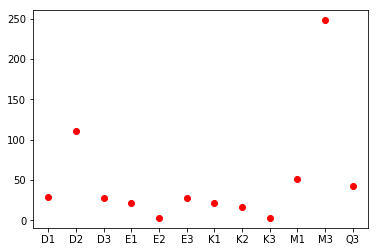

In [48]:
plt.plot(M2, 'ro')
plt.show()

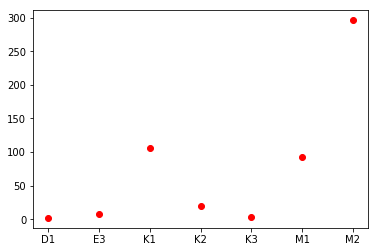

In [49]:
plt.plot(M3, 'ro')
plt.show()

K1, K2, E3, and M1 are zones/beats that are commonly misclassified as both M2 and M3 by the RandomForest.

The following map gives one a good idea of how the misclassified Zones/Beats relate geograpically to the neighborhoods that they are most commonly confused by:

https://www.seattle.gov/police/information-and-data/tweets-by-beat

It is my hypothesis that the census tract number in our dataset is the feature that makes geographically similar locations so likely to be misclassified as each other. 

Next Steps:
I think that a very intriguing path forward for this dataset would be to attempt to classify whether or not a crime occurred at "night", using different definitions of night-time (possibly even working in the time of year as a means of tuning this feature).

I also think that different types of engineered features (like a StandardScaler on the Census Tract 2000 number and omission of PCA) might be worth investigating in the future.

I feel as though I know my way around this dataset pretty well by now, so I expect to develop more models using this data in the near future.